# Added mass - N bodies v2

In [1]:
using ViscousFlow

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [33]:
using LinearAlgebra
using Printf

### First, some generalities

In [4]:
𝐞₁ = [1.0;0.0];
𝐞₂ = [0.0;1.0];
𝐞 = [𝐞₁,𝐞₂];

In [5]:
"""
integrate(f::Function,xmin::Real,xmax::Real,N::Int,name::String) -> Real
Integrate the function `f` between the limits `xmin` to `xmax` with `N` intervals using either the `"trapezoidal"` or `"simpson"` rule specified in `name`. The solution is returned as a Real value.
"""
function surface_integrate(body::Body{N},integrand::Array{Float64,1}) where {N}
    func = Array{Float64,1}(undef, N+1)
    func[1:end-1] .= integrand
    func[end] = integrand[1]
    s = sum(Bodies.dlength(body).*(func[1:end-1] + func[2:end]))
    return s
end

surface_integrate

#### Create the circular shapes, with discrete points and associated regularization and interpolation operator

In [6]:
n = 640
N = 9

NX = Int(ceil(sqrt(N)))
NY = Int(ceil(N/NX))
dX = 3.6

R = 1.0

println("Ratio of gap to cylinder radius = ",(dX-2*R)/R)

bodies = Array{Body,1}(undef, N)

index = 0
for j in 1:NY
    for i in 1:NX
        index = index + 1
        if index > N
            break
        end
        body = Ellipse(R,R,n)
        xc = 1.1*R + dX*(i-1)
        yc = 1.1*R + dX*(j-1)
        T = RigidTransform((xc,yc),0.0)
        T(body)
        bodies[(j-1)*NX+i] = body
    end
end

# Find the minimum arc length
ds = minimum(Bodies.dlength(bodies[1]))

# Area of the circles
𝒱 = π*R^2

# Concatenate coordinates together
bodies_x = vcat((p->p.x).(bodies)...);
bodies_y = vcat((p->p.y).(bodies)...);

# The desired circulation about the cylinders
Γ = zeros(N);

Ratio of gap to cylinder radius = 1.6


Lagrangian data vectors

In [7]:
X = VectorData(bodies_x,bodies_y)
f = ScalarData(X);
ψb = ScalarData(X);
oB = zeros(N*n,N)
for i in 1:N
    oB[((i-1)*n+1):((i-1)*n+n),i] .= 1;
end

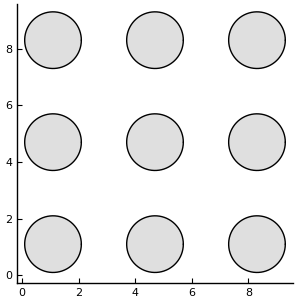

In [8]:
p = plot(size=[300,300])
for i in 1:length(bodies)
    plot!(bodies[i],fillcolor=:gray,fillrange=0,fillalpha=0.25,linecolor=:black);
end
p

#### Create a grid and a Laplacian operator on it

In [9]:
nx = 1000;
Lx = 2.2*R + dX*(NX-1);
display(Lx)
Ly = 2.2*R + dX*(NY-1);
dx = Lx/(nx-2);
ny = Int(ceil(Ly/dx))+2
display(ny)

9.4

1000

In [10]:
maximum(bodies_x)

9.3

Eulerian data vectors

In [11]:
w = Nodes(Dual,(nx,ny)); w .= 0;
ψ = Nodes(Dual,w);

In [12]:
L = plan_laplacian(size(w),with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 1000, ny = 1000) grid with spacing 1.0

In [13]:
println("Ratio of arc spacing to cell size = ",ds/dx)

Ratio of arc spacing to cell size = 1.042319440506745


#### Create the saddle-point system

In [14]:
L⁻¹(w::T) where {T} = L\w;
E = Regularize(X,dx;issymmetric=true);
Hmat,Emat = RegularizationMatrix(E,f,w);
PS = SaddleSystem((w,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true);
S = Matrix(PS.S);
S₀ = transpose(oB)*(S\oB);
T = S - oB*(S₀\transpose(oB));

The added mass coefficient matrix for two degrees of freedom is (2xN)-by-(2xN)

In [15]:
M = zeros(2*N,2*N);

#### Fill added mass matrix

In [23]:
U = zeros(N,1);
V = zeros(N,1);

for k in 1:N
    for j in 1:2 # dimension
    
        U .= 0.0;
        V .= 0.0;
        if j == 1
            U[k] = 1.0;
        else
            V[k] = 1.0;
        end

        for i in 1:N
            ψb[((i-1)*n+1):((i-1)*n+n)] = U[i]*(bodies[i].y .- bodies[i].cent[2]) - V[i]*(bodies[i].x .- bodies[i].cent[1])
        end
                
        f .= S\(T*(S\(Emat*(L\w).+ψb)) .+ oB*(S₀\Γ));
        ψ₀ = -S₀\(Γ - transpose(oB)*(S\(Emat*(L\w) .+ ψb)));
        ψ .= -(L\(Hmat*f))-(L\(w));# .+ ψ₀;  

        for i in 1:N
            integrand_x = (f[(i-1)*n+1:(i-1)*n+n]./Bodies.dlength(bodies[i])).*(bodies[i].y);
            integrand_y = -(f[(i-1)*n+1:(i-1)*n+n]./Bodies.dlength(bodies[i])).*(bodies[i].x);
            Pʲ = 0.5*[surface_integrate(bodies[i],integrand_x);surface_integrate(bodies[i],integrand_y)]
            if i == k
                Pʲ .-= 𝒱*𝐞[j]
            end
            M[(i-1)*2+1,(k-1)*2+j] = dot(Pʲ,𝐞[1])/𝒱
            M[(i-1)*2+2,(k-1)*2+j] = dot(Pʲ,𝐞[2])/𝒱
        end
    end
end

$\begin{bmatrix}
f_{1x}\\
f_{1y}\\
f_{2x}\\
f_{2y}
\end{bmatrix}$ =
-$\begin{bmatrix}
M_{11xx} & M_{11yx} & M_{12xx} & M_{12yx} \\
M_{11xy} & M_{11yy} & M_{12xy} & M_{12yy} \\
M_{21xx} & M_{21yx} & M_{22xx} & M_{22yx} \\
M_{21xy} & M_{21yy} & M_{22xy} & M_{22yy}
\end{bmatrix}$
$\begin{bmatrix}
a_{1x}\\
a_{1y}\\
a_{2x}\\
a_{2y}
\end{bmatrix}$

In [24]:
max_self_added_mass_coef = maximum(M)

1.0860395524091193

Eigenvalues of M

In [25]:
eigM = eigen(M);
max_eig_value_coef = maximum(real(eigM.values))

1.5757562233930376

In [26]:
max_eig_value_coef/max_self_added_mass_coef

1.4509197385100743

In [34]:
map(x -> @sprintf("%.3f",x), M)

18×18 Array{String,2}:
 "1.048"   "0.004"   "-0.158"  "0.017"   …  "-0.030"  "-0.004"  "-0.020"
 "0.004"   "1.048"   "-0.015"  "0.167"      "-0.026"  "-0.020"  "-0.004"
 "-0.158"  "-0.015"  "1.064"   "-0.000"     "0.000"   "0.011"   "-0.024"
 "0.017"   "0.167"   "0.000"   "1.067"      "-0.044"  "-0.030"  "-0.026"
 "-0.037"  "-0.005"  "-0.158"  "-0.017"     "0.030"   "0.045"   "0.005" 
 "0.005"   "0.045"   "0.015"   "0.167"   …  "-0.026"  "-0.005"  "-0.037"
 "0.167"   "0.017"   "-0.022"  "0.091"      "-0.091"  "-0.026"  "-0.030"
 "-0.015"  "-0.158"  "0.074"   "-0.022"     "-0.022"  "-0.024"  "0.011" 
 "-0.021"  "-0.081"  "0.169"   "0.000"      "-0.000"  "-0.021"  "-0.081"
 "-0.081"  "-0.021"  "-0.000"  "-0.162"     "-0.162"  "-0.081"  "-0.021"
 "-0.026"  "-0.030"  "-0.022"  "-0.091"  …  "0.091"   "0.167"   "0.017" 
 "-0.024"  "0.011"   "-0.074"  "-0.022"     "-0.022"  "-0.015"  "-0.158"
 "0.045"   "0.005"   "0.011"   "0.030"      "-0.017"  "-0.037"  "-0.005"
 "-0.005"  "-0.037"  "0.024"

In [32]:
?printf

search: print println printstyled sprint isprint plan_constraints

Couldn't find printf
Perhaps you meant print, println, sprint, isprint, parent, pointer or pinv


No documentation found.

Binding `printf` does not exist.


#### Plot the last step

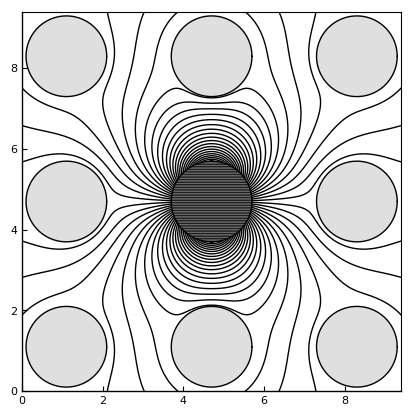

In [20]:
xg,yg = coordinates(ψ,dx=dx)
p = plot(xg,yg,ψ,linecolor=:black,levels=range(-1,1,length=50))
for i in 1:length(bodies)
    plot!(bodies[i],fillcolor=:gray,fillrange=0,fillalpha=0.25,linecolor=:black);
end
plot!(xlims=(0,Lx),ylims=(0,Lx),legend=false,size=[400,400])
savefig("added_mass_n_bodies.pdf")

In [21]:
sum(f[n+1:2n])

3.4730248191228164e-15

In [36]:
bodies[5]

Elliptical body with 640 points and semi-axes (1.0,1.0)
   Current position: (4.7,4.7)
   Current angle (rad): 0.0


In [38]:
Ly

9.4